In [1]:
import numpy as np
from functools import reduce
from collections import namedtuple
from typing import List, Tuple, Union

MAXSIDE = 100
MAXAREA = 40 * 40
MAXPIXELS = 40 * 40 * 5

import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src', 'arclang')))
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from image import Image, Point

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
# from arclang.image import Image, Piece
from matplotlib.colors import ListedColormap, BoundaryNorm

def display_matrix(matrix):
    colors = [
        "#000000",  # black
        "#0074D9",  # blue
        "#FF4136",  # red
        "#2ECC40",  # green
        "#FFDC00",  # yellow
        "#AAAAAA",  # grey
        "#F012BE",  # fuchsia
        "#FF851B",  # orange
        "#7FDBFF",  # teal
        "#870C25",  # brown
    ]
    cmap = ListedColormap(colors)
    bounds = np.arange(-0.5, 10, 1)
    norm = BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    cax = ax.matshow(matrix.mask, cmap=cmap, norm=norm)
    ax.set_title("Matrix")

    fig.colorbar(
        cax, ax=ax, ticks=np.arange(0, 10), orientation="vertical"
    ).ax.set_yticklabels(
        [
            "Symbol 0",
            "Symbol 1",
            "Symbol 2",
            "Symbol 3",
            "Symbol 4",
            "Symbol 5",
            "Symbol 6",
            "Symbol 7",
            "Symbol 8",
            "Symbol 9",
        ]
    )

    plt.show()

In [3]:
path = "/home/sai/Desktop/arc/ARC-AGI/data/training/ce9e57f2.json"
with open(path,"r") as f:
    data_ce9 = json.loads(f.read())

In [4]:
img_mask = data_ce9["train"][0]["input"]
img_mask = np.array(img_mask)
img_mask.shape

(7, 9)

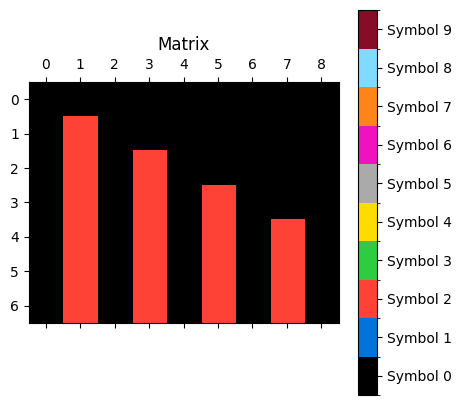

In [5]:
input_img= Image(0,0,9,7,img_mask)
display_matrix(input_img)

In [6]:
from function import *

In [7]:
input_img.list_same_color_components()

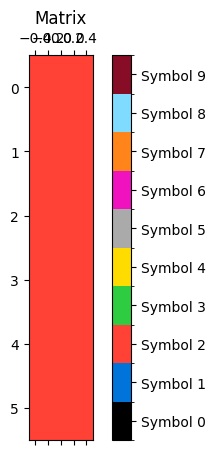

In [13]:
s = split_all(input_img)
display_matrix(s[0])

In [10]:
display_matrix(combine_images(split_all(input_img)))

TypeError: cannot unpack non-iterable int object

In [9]:
columns = input_img.list_components()

In [10]:
# display_matrix(half(columns[1],3))

In [51]:
columns[1].mask

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0]], dtype=int8)

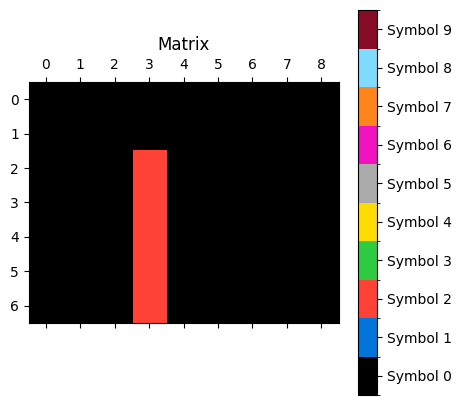

In [52]:
display_matrix(columns[1])

In [20]:
def col(id: int) -> Image:
    assert 0 <= id < 10
    return Image.full(Point(0, 0), Point(1, 1), id)

In [28]:
col

In [24]:
blue_bottoms = []
for col in columns:
    # Create a blue column of the same height as the original
    blue_col = Image.full(Point(col.x, col.y), Point(col.w, col.h), 2)  # Assuming 2 represents blue
    
    # Get the top half of the original column
    top_half = half(col, 2)
    
    # Combine the red top half with the blue bottom half
    new_col = compose_id(top_half, blue_col, 3)  # 3 means overlay top_half on blue_col
    
    blue_bottoms.append(new_col)

In [25]:
result = compose_growing(blue_bottoms)

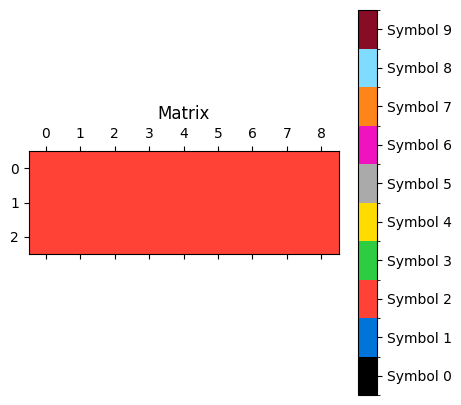

In [27]:
display_matrix(result)

In [53]:
from typing import List, Tuple
import numpy as np

def find_smallest_component(img: Image) -> Tuple[Image, Point]:
    def split_all_with_position(img: Image) -> List[Tuple[Image, Point]]:
        ret = []
        done = Image.empty(img.x, img.y, img.w, img.h)

        def dfs(r: int, c: int, col: int, toadd: Image):
            if r < 0 or r >= img.h or c < 0 or c >= img.w or img[r, c] != col or done[r, c]:
                return
            toadd[r, c] = img[r, c]
            done[r, c] = 1
            for d in range(4):
                nr = r + (d == 0) - (d == 1)
                nc = c + (d == 2) - (d == 3)
                dfs(nr, nc, col, toadd)

        for i in range(img.h):
            for j in range(img.w):
                if not done[i, j] and img[i, j] != 0:  # Skip background (0)
                    toadd = Image.empty(img.x, img.y, img.w, img.h)
                    dfs(i, j, img[i, j], toadd)
                    toadd = compress(toadd)
                    if toadd.count() > 0:
                        ret.append((toadd, Point(toadd.x, toadd.y)))

        return ret

    components = split_all_with_position(img)
    
    if not components:
        return Image(), Point(0, 0)  # Return empty image and (0,0) if no components found

    # Find the smallest component
    smallest = min(components, key=lambda x: x[0].count())
    
    return smallest[0], smallest[1]

# Test the function
test_array = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0]
])

test_image = Image(0, 0, 9, 7, test_array)
smallest_component, position = find_smallest_component(test_image)

print("Smallest component:")
print(smallest_component.mask)
print(f"Position: ({position.x}, {position.y})")

Smallest component:
[[2]
 [2]
 [2]
 [2]
 [2]]
Position: (3, 2)


In [55]:
from typing import List, Tuple
import numpy as np

def list_components(img: Image) -> List[Tuple[Image, Point]]:
    def split_all_with_position(img: Image) -> List[Tuple[Image, Point]]:
        ret = []
        done = Image.empty(img.x, img.y, img.w, img.h)

        def dfs(r: int, c: int, col: int, toadd: Image):
            if r < 0 or r >= img.h or c < 0 or c >= img.w or img[r, c] != col or done[r, c]:
                return
            toadd[r, c] = img[r, c]
            done[r, c] = 1
            for d in range(4):
                nr = r + (d == 0) - (d == 1)
                nc = c + (d == 2) - (d == 3)
                dfs(nr, nc, col, toadd)

        for i in range(img.h):
            for j in range(img.w):
                if not done[i, j] and img[i, j] != 0:  # Skip background (0)
                    toadd = Image.empty(img.x, img.y, img.w, img.h)
                    dfs(i, j, img[i, j], toadd)
                    toadd = compress(toadd)
                    if toadd.count() > 0:
                        ret.append((toadd, Point(j, i)))  # Use original (j, i) as the starting point

        return ret

    return split_all_with_position(img)

# Test the function
test_array = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 2, 0, 0],
    [0, 0, 0, 2, 0, 0, 2, 0, 0],
    [0, 0, 0, 2, 0, 0, 2, 0, 0],
    [0, 0, 0, 2, 0, 0, 2, 0, 0],
    [0, 0, 0, 2, 0, 0, 0, 0, 0]
])

test_image = Image(0, 0, 9, 7, test_array)
components = list_components(test_image)

print(f"Number of components: {len(components)}")
for i, (component, position) in enumerate(components, 1):
    print(f"\nComponent {i}:")
    print(component.mask)
    print(f"Position: ({position.x}, {position.y})")

Number of components: 2

Component 1:
[[2]
 [2]
 [2]
 [2]
 [2]]
Position: (3, 2)

Component 2:
[[2]
 [2]
 [2]
 [2]]
Position: (6, 2)
